<a href="https://colab.research.google.com/github/kamranr123/kamranr123.github.io/blob/master/SD_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> KM Colab</h1>

In [1]:
# @title ## Choose Models
import markdown
import zipfile
import shutil
import os
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from importlib import reload

# ******************************************************************************
class Modelpaths:
    base_path = '/content/models'
    model = f'{base_path}/checkpoints'
    lora = f'{base_path}/loras'
    vae = f'{base_path}/vae'
    upscale = f'{base_path}/upscale_models'
    controlnet = f'{base_path}/controlnet'
    embeddings = f'{base_path}/embeddings'
    diffusers = f'{base_path}/diffusers'

    def __init__(self):
        if not os.path.exists(self.base_path):
            os.makedirs(self.model)
            os.makedirs(self.lora)
            os.makedirs(self.vae)
            os.makedirs(self.upscale)
            os.makedirs(self.embeddings)
            os.makedirs(self.diffusers)

modelpaths = Modelpaths()

%cd /content
!apt -y install -qq aria2

def download(model_link, model_name, path = ''):

    if path == '':
        path = modelpaths.model

    %cd {path}
    if path == modelpaths.model:
        !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {model_link} --dir={path} --out={model_name}
    else:
        !aria2c --console-log-level=error -c -x 16 -s 8 -k 1M {model_link} --dir={path} --out={model_name}
# ******************************************************************************
clear_output()

!wget -q https://raw.githubusercontent.com/kamranr123/kamranr123.github.io/master/modellist.py -P /content/
import modellist
reload(modellist)
available_model_dict = modellist.available_model_dict
# ******************************************************************************
# initialize values
model = list(available_model_dict.keys())[0]
model_ver = available_model_dict[model][0]
model_name = available_model_dict[model][4]
model_link = available_model_dict[model][3] + model_name
if 'civitai.com' in model_link:
    model_link = available_model_dict[model][3]

# Define the title and link
title = "Model selection"
link = "https://github.com/NUROISEA/anime-webui-colab/wiki/Selecting-a-model"

# Generate the Markdown-formatted text
markdown_text = f"# {title} [**[?]**]({link})"

# Convert the Markdown text to HTML
html = markdown.markdown(markdown_text)
display(Markdown(html))

# Create a list of models for the first selection listbox
model_options = list(available_model_dict.keys())

# Create the first selection listbox widget for models
model_selection = widgets.Select(
    options=model_options,
    description='Choose a model:',
    style={'description_width': 'initial'}
)

# Create the second selection listbox widget for values
model_version_selection = widgets.Select(
    options = available_model_dict[model_options[0]][4:],
    description='Choose a model version:',
    style={'description_width': 'initial'}
)

# Define a function to handle the model selection change event
def on_model_selection_change(change):
    global model
    model = change['new']
    print('change')
    selected_values = available_model_dict[model][4:]
    model_version_selection.options = selected_values

# Attach the model selection change event handler
model_selection.observe(on_model_selection_change, 'value')

# Define a function to handle the model selection change event
def on_model_version_selection_change(change):
    global model_name, model_link, model_ver
    model_name = change['new']
    model_link = available_model_dict[model][3] + model_name
    model_ver = available_model_dict[model][0]
    if 'civitai.com' in model_link:
        model_link = available_model_dict[model][3]
    print("\r", end="")
    print("Selected Model: {}, Version: {}".format(model, model_name), end="")
    # print("Selected Model link: {}".format(model_link), end="")

# Attach the model version selection change event handler
model_version_selection.observe(on_model_version_selection_change, 'value')

# Display the selection listboxes
display(model_selection)
display(model_version_selection)
print("Selected Model: {}, Version: {}".format(model, model_name), end="")


<h1>Model selection <a href="https://github.com/NUROISEA/anime-webui-colab/wiki/Selecting-a-model"><strong>[?]</strong></a></h1>

Select(description='Choose a model:', options=('Stable Diffusion v1.5', 'Dark Sushi Mix', 'ExpMix Line', 'Cham…

Select(description='Choose a model version:', options=('v1-5-pruned.safetensors', 'v1-5-pruned-emaonly.safeten…

Selected Model: Stable Diffusion v1.5, Version: v1-5-pruned.safetensorschange
Selected Model: KenCanMix, Version: kencanmix_v20Beta.safetensors

In [3]:
download(model_link, model_name, modelpaths.model)

!wget -q 'https://huggingface.co/nolanaatama/colab/resolve/main/embeddings.zip' -P {modelpaths.embeddings}
with zipfile.ZipFile(f"{modelpaths.embeddings}/embeddings.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{modelpaths.base_path}")
os.remove(f"{modelpaths.embeddings}/embeddings.zip")

/content/models/checkpoints

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
aeae2e|OK  |       0B/s|/content/models/checkpoints/kencanmix_v20Beta.safetensors

Status Legend:
(OK):download completed.


# Initial

In [4]:
!pip install diffusers transformers accelerate omegaconf
# !pip install xformers==0.0.2
import torch
import transformers
from diffusers import AutoPipelineForText2Image, DiffusionPipeline, StableDiffusionPipeline
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
from diffusers import DPMSolverSinglestepScheduler, KDPM2DiscreteScheduler, KDPM2AncestralDiscreteScheduler
from diffusers import HeunDiscreteScheduler, LMSDiscreteScheduler, DEISMultistepScheduler, UniPCMultistepScheduler

%cd /content
!git clone https://github.com/huggingface/diffusers
clear_output()

In [ ]:
from enum import Enum
import math
import safetensors
import torch
import re

# clip_text_custom_embedder.py
# copied and customized from automatic1111 sd_hijack.py & prompt_parser.py
# https://github.com/AUTOMATIC1111/stable-diffusion-webui/blob/ec1924ee5789b72c31c65932b549c59ccae0cdd6/modules/sd_hijack.py#L113
# https://github.com/AUTOMATIC1111/stable-diffusion-webui/blob/ec1924ee5789b72c31c65932b549c59ccae0cdd6/modules/prompt_parser.py#L259

re_attention = re.compile(r"""
\\\(|
\\\{|
\\\)|
\\\}|
\\\[|
\\]|
\\\\|
\\|
\(|
\{|
\[|
:([+-]?[.\d]+)\)|
\)|
\}|
]|
[^\\()\\{}\[\]:]+|
:
""", re.X)


def parse_prompt_attention(text):
    """
    Parses a string with attention tokens and returns a list of pairs: text and its assoicated weight.
    Accepted tokens are:
      (abc) - increases attention to abc by a multiplier of 1.1
      (abc:3.12) - increases attention to abc by a multiplier of 3.12
      [abc] - decreases attention to abc by a multiplier of 1.1
      \( - literal character '('
      \[ - literal character '['
      \) - literal character ')'
      \] - literal character ']'
      \\ - literal character '\'
      anything else - just text
    >>> parse_prompt_attention('normal text')
    [['normal text', 1.0]]
    >>> parse_prompt_attention('an (important) word')
    [['an ', 1.0], ['important', 1.1], [' word', 1.0]]
    >>> parse_prompt_attention('(unbalanced')
    [['unbalanced', 1.1]]
    >>> parse_prompt_attention('\(literal\]')
    [['(literal]', 1.0]]
    >>> parse_prompt_attention('(unnecessary)(parens)')
    [['unnecessaryparens', 1.1]]
    >>> parse_prompt_attention('a (((house:1.3)) [on] a (hill:0.5), sun, (((sky))).')
    [['a ', 1.0],
     ['house', 1.5730000000000004],
     [' ', 1.1],
     ['on', 1.0],
     [' a ', 1.1],
     ['hill', 0.55],
     [', sun, ', 1.1],
     ['sky', 1.4641000000000006],
     ['.', 1.1]]
    """

    res = []
    round_brackets = []
    square_brackets = []

    round_bracket_multiplier = 1.1
    square_bracket_multiplier = 1 / 1.1

    def multiply_range(start_position, multiplier):
        for p in range(start_position, len(res)):
            res[p][1] *= multiplier

    for m in re_attention.finditer(text):
        text = m.group(0)
        weight = m.group(1)

        if text.startswith('\\'):
            res.append([text[1:], 1.0])
        elif text == '(' or text == '{':
            round_brackets.append(len(res))
        elif text == '[':
            square_brackets.append(len(res))
        elif weight is not None and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), float(weight))
        elif (text == ')' or text == '}') and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), round_bracket_multiplier)
        elif text == ']' and len(square_brackets) > 0:
            multiply_range(square_brackets.pop(), square_bracket_multiplier)
        else:
            res.append([text, 1.0])

    for pos in round_brackets:
        multiply_range(pos, round_bracket_multiplier)

    for pos in square_brackets:
        multiply_range(pos, square_bracket_multiplier)

    if len(res) == 0:
        res = [["", 1.0]]

    # merge runs of identical weights
    i = 0
    while i + 1 < len(res):
        if res[i][1] == res[i + 1][1]:
            res[i][0] += res[i + 1][0]
            res.pop(i + 1)
        else:
            i += 1

    return res


class CLIPTextCustomEmbedder(object):
    def __init__(self, tokenizer, text_encoder, device,
                 clip_stop_at_last_layers=1):
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.token_mults = {}
        self.device = device
        self.clip_stop_at_last_layers = clip_stop_at_last_layers

    def tokenize_line(self, line):
        def get_target_prompt_token_count(token_count):
            return math.ceil(max(token_count, 1) / 75) * 75

        id_end = self.tokenizer.eos_token_id
        parsed = parse_prompt_attention(line)
        tokenized = self.tokenizer(
            [text for text, _ in parsed], truncation=False,
            add_special_tokens=False)["input_ids"]

        fixes = []
        remade_tokens = []
        multipliers = []

        for tokens, (text, weight) in zip(tokenized, parsed):
            i = 0
            while i < len(tokens):
                token = tokens[i]
                remade_tokens.append(token)
                multipliers.append(weight)
                i += 1

        token_count = len(remade_tokens)
        prompt_target_length = get_target_prompt_token_count(token_count)
        tokens_to_add = prompt_target_length - len(remade_tokens)
        remade_tokens = remade_tokens + [id_end] * tokens_to_add
        multipliers = multipliers + [1.0] * tokens_to_add
        return remade_tokens, fixes, multipliers, token_count

    def process_text(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        remade_batch_tokens = []
        cache = {}
        batch_multipliers = []
        for line in texts:
            if line in cache:
                remade_tokens, fixes, multipliers = cache[line]
            else:
                remade_tokens, fixes, multipliers, _ = self.tokenize_line(line)
                cache[line] = (remade_tokens, fixes, multipliers)

            remade_batch_tokens.append(remade_tokens)
            batch_multipliers.append(multipliers)

        return batch_multipliers, remade_batch_tokens

    def __call__(self, text):
        batch_multipliers, remade_batch_tokens = self.process_text(text)

        z = None
        i = 0
        while max(map(len, remade_batch_tokens)) != 0:
            rem_tokens = [x[75:] for x in remade_batch_tokens]
            rem_multipliers = [x[75:] for x in batch_multipliers]

            tokens = []
            multipliers = []
            for j in range(len(remade_batch_tokens)):
                if len(remade_batch_tokens[j]) > 0:
                    tokens.append(remade_batch_tokens[j][:75])
                    multipliers.append(batch_multipliers[j][:75])
                else:
                    tokens.append([self.tokenizer.eos_token_id] * 75)
                    multipliers.append([1.0] * 75)

            z1 = self.process_tokens(tokens, multipliers)
            z = z1 if z is None else torch.cat((z, z1), axis=-2)

            remade_batch_tokens = rem_tokens
            batch_multipliers = rem_multipliers
            i += 1

        return z

    def process_tokens(self, remade_batch_tokens, batch_multipliers):
        remade_batch_tokens = [[self.tokenizer.bos_token_id] + x[:75] +
                               [self.tokenizer.eos_token_id] for x in remade_batch_tokens]
        batch_multipliers = [[1.0] + x[:75] + [1.0] for x in batch_multipliers]

        tokens = torch.asarray(remade_batch_tokens).to(self.device)
        # print(tokens.shape)
        # print(tokens)
        outputs = self.text_encoder(
            input_ids=tokens, output_hidden_states=True)

        if self.clip_stop_at_last_layers > 1:
            z = self.text_encoder.text_model.final_layer_norm(
                outputs.hidden_states[-self.clip_stop_at_last_layers])
        else:
            z = outputs.last_hidden_state

        # restoring original mean is likely not correct, but it seems to work well
        # to prevent artifacts that happen otherwise
        batch_multipliers_of_same_length = [
            x + [1.0] * (75 - len(x)) for x in batch_multipliers]
        batch_multipliers = torch.asarray(
            batch_multipliers_of_same_length).to(self.device)
        # print(batch_multipliers.shape)
        # print(batch_multipliers)

        original_mean = z.mean()
        z *= batch_multipliers.reshape(batch_multipliers.shape +
                                       (1,)).expand(z.shape)
        new_mean = z.mean()
        z *= original_mean / new_mean

        return z

    def get_text_tokens(self, text):
        batch_multipliers, remade_batch_tokens = self.process_text(text)
        return [[self.tokenizer.bos_token_id] + remade_batch_tokens[0]], \
            [[1.0] + batch_multipliers[0]]


def text_embeddings_equal_len(text_embedder, prompt, negative_prompt):
    cond_embeddings = text_embedder(prompt)
    uncond_embeddings = text_embedder(negative_prompt)

    cond_len = cond_embeddings.shape[1]
    uncond_len = uncond_embeddings.shape[1]
    if cond_len == uncond_len:
        return cond_embeddings, uncond_embeddings
    else:
        if cond_len > uncond_len:
            n = (cond_len - uncond_len) // 77
            return cond_embeddings, torch.cat([uncond_embeddings] + [text_embedder("")]*n, dim=1)
        else:
            n = (uncond_len - cond_len) // 77
            return torch.cat([cond_embeddings] + [text_embedder("")]*n, dim=1), uncond_embeddings


def text_embeddings(pipe, prompt, negative_prompt, clip_stop_at_last_layers=1):
    text_embedder = CLIPTextCustomEmbedder(tokenizer=pipe.tokenizer,
                                           text_encoder=pipe.text_encoder,
                                           device=pipe.text_encoder.device,
                                           clip_stop_at_last_layers=clip_stop_at_last_layers)
    cond_embeddings, uncond_embeddings = text_embeddings_equal_len(text_embedder, prompt, negative_prompt)
    return cond_embeddings, uncond_embeddings
# *******************************************************


# modified from https://github.com/kohya-ss/sd-scripts/blob/ad5f318d066c52e5b27306b399bc87e41f2eef2b/networks/lora.py#L17
class LoRAModule(torch.nn.Module):
    def __init__(
        self, org_module: torch.nn.Module, lora_dim=4, alpha=1.0, multiplier=1.0
    ):
        """if alpha == 0 or None, alpha is rank (no scaling)."""
        super().__init__()

        if org_module.__class__.__name__ == "Conv2d":
            in_dim = org_module.in_channels
            out_dim = org_module.out_channels
        else:
            in_dim = org_module.in_features
            out_dim = org_module.out_features

        self.lora_dim = lora_dim

        if org_module.__class__.__name__ == "Conv2d":
            kernel_size = org_module.kernel_size
            stride = org_module.stride
            padding = org_module.padding
            self.lora_down = torch.nn.Conv2d(
                in_dim, self.lora_dim, kernel_size, stride, padding, bias=False
            )
            self.lora_up = torch.nn.Conv2d(
                self.lora_dim, out_dim, (1, 1), (1, 1), bias=False
            )
        else:
            self.lora_down = torch.nn.Linear(in_dim, self.lora_dim, bias=False)
            self.lora_up = torch.nn.Linear(self.lora_dim, out_dim, bias=False)

        if alpha is None or alpha == 0:
            self.alpha = self.lora_dim
        else:
            if type(alpha) == torch.Tensor:
                alpha = alpha.detach().float().numpy()  # without casting, bf16 causes error
            self.register_buffer("alpha", torch.tensor(alpha))  # Treatable as a constant.

        # same as microsoft's
        torch.nn.init.kaiming_uniform_(self.lora_down.weight, a=math.sqrt(5))
        torch.nn.init.zeros_(self.lora_up.weight)

        self.multiplier = multiplier

    def forward(self, x):
        scale = self.alpha / self.lora_dim
        down= self.lora_down(x)
        up= self.lora_up(down)
        return self.multiplier * scale * up


class LoRAModuleContainer(torch.nn.Module):
    def __init__(self, hooks, state_dict, multiplier):
        super().__init__()
        self.multiplier = multiplier

        # Create LoRAModule from state_dict information
        for key, value in state_dict.items():
            if "lora_down" in key:
                lora_name = key.split(".")[0]
                lora_dim = value.size()[0]
                lora_name_alpha = key.split(".")[0] + '.alpha'
                alpha = None
                if lora_name_alpha in state_dict:
                    alpha = state_dict[lora_name_alpha].item()
                hook = hooks[lora_name]
                lora_module = LoRAModule(
                    hook.orig_module, lora_dim=lora_dim, alpha=alpha, multiplier=multiplier
                )
                self.register_module(lora_name, lora_module)

        # Load whole LoRA weights
        self.load_state_dict(state_dict)

        # Register LoRAModule to LoRAHook
        for name, module in self.named_modules():
            if module.__class__.__name__ == "LoRAModule":
                hook = hooks[name]
                hook.append_lora(module)
    @property
    def alpha(self):
        return self.multiplier

    @alpha.setter
    def alpha(self, multiplier):
        self.multiplier = multiplier
        for name, module in self.named_modules():
            if module.__class__.__name__ == "LoRAModule":
                module.multiplier = multiplier

    def remove_from_hooks(self, hooks):
        for name, module in self.named_modules():
            if module.__class__.__name__ == "LoRAModule":
                hook = hooks[name]
                hook.remove_lora(module)
                del module


class LoRAHook(torch.nn.Module):
    """
    replaces forward method of the original Linear,
    instead of replacing the original Linear module.
    """

    def __init__(self):
        super().__init__()
        self.lora_modules = []

    def install(self, orig_module):
        assert not hasattr(self, "orig_module")
        self.orig_module = orig_module
        self.orig_forward = self.orig_module.forward
        self.orig_module.forward = self.forward

    def uninstall(self):
        assert hasattr(self, "orig_module")
        self.orig_module.forward = self.orig_forward
        del self.orig_forward
        del self.orig_module

    def append_lora(self, lora_module):
        self.lora_modules.append(lora_module)

    def remove_lora(self, lora_module):
        self.lora_modules.remove(lora_module)

    def forward(self, x):
        if len(self.lora_modules) == 0:
            return self.orig_forward(x)
        lora = torch.sum(torch.stack([lora(x) for lora in self.lora_modules]), dim=0)
        return self.orig_forward(x) + lora


class LoRAHookInjector(object):
    def __init__(self):
        super().__init__()
        self.hooks = {}
        self.device = None
        self.dtype = None

    def _get_target_modules(self, root_module, prefix, target_replace_modules):
        target_modules = []
        for name, module in root_module.named_modules():
            if (
                module.__class__.__name__ in target_replace_modules
                and not "transformer_blocks" in name
            ):  # to adapt latest diffusers:
                for child_name, child_module in module.named_modules():
                    is_linear = child_module.__class__.__name__ == "Linear"
                    is_conv2d = child_module.__class__.__name__ == "Conv2d"
                    if is_linear or is_conv2d:
                        lora_name = prefix + "." + name + "." + child_name
                        lora_name = lora_name.replace(".", "_")
                        target_modules.append((lora_name, child_module))
        return target_modules

    def install_hooks(self, pipe):
        """Install LoRAHook to the pipe."""
        assert len(self.hooks) == 0
        text_encoder_targets = self._get_target_modules(
            pipe.text_encoder, "lora_te", ["CLIPAttention", "CLIPMLP"]
        )
        unet_targets = self._get_target_modules(
            pipe.unet, "lora_unet", ["Transformer2DModel", "Attention"]
        )
        for name, target_module in text_encoder_targets + unet_targets:
            hook = LoRAHook()
            hook.install(target_module)
            self.hooks[name] = hook

        self.device = pipe.device
        self.dtype = pipe.unet.dtype

    def uninstall_hooks(self):
        """Uninstall LoRAHook from the pipe."""
        for k, v in self.hooks.items():
            v.uninstall()
        self.hooks = {}

    def apply_lora(self, filename, alpha=1.0,dtype=torch.float32):
        """Load LoRA weights and apply LoRA to the pipe."""
        assert len(self.hooks) != 0
        self.dtype = dtype
        state_dict = safetensors.torch.load_file(filename)
        container = LoRAModuleContainer(self.hooks, state_dict, alpha)
        container.to(self.device, self.dtype)
        return container

    def remove_lora(self, container):
        """Remove the individual LoRA from the pipe."""
        container.remove_from_hooks(self.hooks)


class SDLoader:

    class Scheduler(Enum):
        Euler = 1
        Euler_a = 2
        DPM_PP_2M = 3
        DPM_PP_2M_SDE = 4
        DPM_PP_SDE = 5
        DPM2 = 6
        DPM2_a = 7
        Heun = 8
        LMS = 9
        DEIS = 10
        UniPC = 11

    __device_name = "cuda"
    __torch_dtype = torch.float16
    _pipe = None
    _scheduler_type = Scheduler.Euler
    __default_clip_skip=1
    _clip_skip = __default_clip_skip
    _model_diffuser_path=None
    __original_clip_layers=None
    __loaded_embeddings = []
    seed = 0

    def __init__(self) -> None:
        if not torch.cuda.is_available():
            self.__device_name = torch.device("cpu")
            self.__torch_dtype = torch.float32

        pass

    def __install_lora_hook(self, pipe: DiffusionPipeline):
        """Install LoRAHook to the pipe."""
        assert not hasattr(pipe, "lora_injector")
        assert not hasattr(pipe, "apply_lora")
        assert not hasattr(pipe, "remove_lora")
        injector = LoRAHookInjector()
        injector.install_hooks(pipe)
        pipe.lora_injector = injector
        pipe.apply_lora = injector.apply_lora
        pipe.remove_lora = injector.remove_lora

    def __uninstall_lora_hook(self, pipe: DiffusionPipeline):
        """Uninstall LoRAHook from the pipe."""
        pipe.lora_injector.uninstall_hooks()
        del pipe.lora_injector
        del pipe.apply_lora
        del pipe.remove_lora

    def __convert_lora_to_diffuser(self, lora):
        script = '/content/diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py'
        mname = lora.split('.')[0] + '/'
        if lora.endswith('.safetensors'):
            !python {script} --checkpoint_path {modelpaths.lora + '/' + lora} --dump_path {modelpaths.lora + '/' + mname} --from_safetensors
        else:
            !python {script} --checkpoint_path {modelpaths.lora + '/' + lora} --dump_path {modelpaths.lora + '/' + mname}
        pass

    def __convert_model_to_diffuser(self, model):
        script = '/content/diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py'
        mname = model.split('.')[0] + '/'
        if model.endswith('.safetensors'):
            !python {script} --checkpoint_path {modelpaths.model + '/' + model} --dump_path {modelpaths.diffusers + '/' + mname} --from_safetensors
        else:
            !python {script} --checkpoint_path {modelpaths.model + '/' + model} --dump_path {modelpaths.diffusers + '/' + mname}
        pass

    def loadModel(self, safetensors_model, clip_skip=2):
        self._model_diffuser_path = modelpaths.model + '/' + safetensors_model
        if not os.path.exists(self._model_diffuser_path):
            print(f"{safetensors_model} not found !")
            return
        if self._pipe is not None:
            print("unload the last model before continue!")
            return

        self._pipe = StableDiffusionPipeline.from_single_file(self._model_diffuser_path,
                                    torch_dtype=self.__torch_dtype, load_safety_checker=False)
        self._pipe = self._pipe.to(self.__device_name)
        # self._pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
        self.change_scheduler(self._scheduler_type, True)

        self.__original_clip_layers = self._pipe.text_encoder.text_model.encoder.layers
        self.setClipSkip(self._clip_skip)
        self.reload_embeddings()
        self.__install_lora_hook(self._pipe)

    def setClipSkip(self, clip_skip):
        if self._pipe is None:
            print('no model loaded!')
            return
        self._clip_skip = clip_skip

        if clip_skip > 1:
            self._pipe.text_encoder.text_model.encoder.layers = self.__original_clip_layers[:-(clip_skip-1)]

    def change_scheduler(self, scheduler: Scheduler, karras=False):
        if self._pipe is None:
            print('no model loaded!')
            return

        if scheduler == SDLoader.Scheduler.Euler:
            self._pipe.scheduler = EulerDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.Euler_a:
            self._pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM_PP_2M:
            self._pipe.scheduler = DPMSolverMultistepScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM_PP_2M_SDE:
            self._pipe.scheduler = DPMSolverMultistepScheduler.from_config(self._pipe.scheduler.config)
            self._pipe.scheduler.algorithm_type="sde-dpmsolver++"
        elif scheduler == SDLoader.Scheduler.DPM_PP_SDE:
            self._pipe.scheduler = DPMSolverSinglestepScheduler.from_config(self._pipe.scheduler.config)
            self._pipe.scheduler.algorithm_type="sde-dpmsolver++"
        elif scheduler == SDLoader.Scheduler.DPM2:
            self._pipe.scheduler = KDPM2DiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM2_a:
            self._pipe.scheduler = KDPM2AncestralDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.Heun:
            self._pipe.scheduler = HeunDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.LMS:
            self._pipe.scheduler = LMSDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DEIS:
            self._pipe.scheduler = DEISMultistepScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.UniPC:
            self._pipe.scheduler = UniPCMultistepScheduler.from_config(self._pipe.scheduler.config)

        self._pipe.scheduler.use_karras_sigmas=karras

    def unload(self):
        if self._pipe is not None:
            self.__uninstall_lora_hook(self._pipe)
            self._pipe.maybe_free_model_hooks()
            self._pipe = None
            self._model_diffuser_path=None
            self.__loaded_embeddings=[]
            self.__original_clip_layers=None
            self.clip_skip=self.__default_clip_skip

    def __get_pipeline_embeds(self, prompt, negative_prompt):
        """ Get pipeline embeds for prompts bigger than the maxlength of the pipe
        :param prompt:
        :param negative_prompt:
        :return:
        """
        max_length = self._pipe.tokenizer.model_max_length

        # simple way to determine length of tokens
        count_prompt = len(prompt.split(" "))
        count_negative_prompt = len(negative_prompt.split(" "))

        # create the tensor based on which prompt is longer
        if count_prompt >= count_negative_prompt:
            input_ids = self._pipe.tokenizer(prompt, return_tensors="pt", truncation=False).input_ids.to(self.__device_name)
            shape_max_length = input_ids.shape[-1]
            negative_ids = self._pipe.tokenizer(negative_prompt, truncation=False, padding="max_length",
                                            max_length=shape_max_length, return_tensors="pt").input_ids.to(self.__device_name)

        else:
            negative_ids = self._pipe.tokenizer(negative_prompt, return_tensors="pt", truncation=False).input_ids.to(self.__device_name)
            shape_max_length = negative_ids.shape[-1]
            input_ids = self._pipe.tokenizer(prompt, return_tensors="pt", truncation=False, padding="max_length",
                                        max_length=shape_max_length).input_ids.to(self.__device_name)

        concat_embeds = []
        neg_embeds = []
        for i in range(0, shape_max_length, max_length):
            concat_embeds.append(self._pipe.text_encoder(input_ids[:, i: i + max_length])[0])
            neg_embeds.append(self._pipe.text_encoder(negative_ids[:, i: i + max_length])[0])

        return torch.cat(concat_embeds, dim=1), torch.cat(neg_embeds, dim=1)

    def __extract_filename(self, full_path):
        filename = os.path.basename(full_path)
        return os.path.splitext(filename)[0]

    def __read_file_list(self, directory, extension):
        file_list = []
        for filename in os.listdir(directory):
            for ext in extension.split('|'):
                if filename.endswith(ext):
                    file_list.append(filename)
        return file_list

    def reload_embeddings(self):
        print('reload_embeddings')
        if self._pipe is None:
            print('no model loaded!')
            return

        current_file_list = self.__read_file_list(modelpaths.embeddings, '.pt|.bin|.safetensors')
        for embeddingsfile in current_file_list:
            if embeddingsfile not in self.__loaded_embeddings:
                try:
                    self._pipe.load_textual_inversion(modelpaths.embeddings + '/' + embeddingsfile, token=self.__extract_filename(embeddingsfile))
                    self.__loaded_embeddings.append(embeddingsfile)
                except Exception as e:
                    print(f'error loading {embeddingsfile}')

        print('finish reload_embeddings: total loaded = ' + str(len(self.__loaded_embeddings)))

    def run(self, prompt, negative_prompt, step=20, gs=6, w=512, h=512, batch=1):
        if self._pipe is None:
            print('no model loaded!')
            return

        # p, np = self.__get_pipeline_embeds(prompt, negative_prompt)
        p, np = text_embeddings(self._pipe, prompt, negative_prompt, clip_stop_at_last_layers=self._clip_skip)

        image = self._pipe(prompt_embeds=p, negative_prompt_embeds=np, generator=torch.manual_seed(self.seed),
            height=h, width=w, guidance_scale=gs, num_inference_steps=step, num_images_per_prompt=batch).images

        return image
        # for i in range(batch):
        #     image[i].save(f"./image{i+1}.png")

    def getPip(self):
        return self._pipe


sdloader = SDLoader()
sdloader.loadModel('kencanmix_v20Beta.safetensors')

  0%|          | 0/30 [00:00<?, ?it/s]

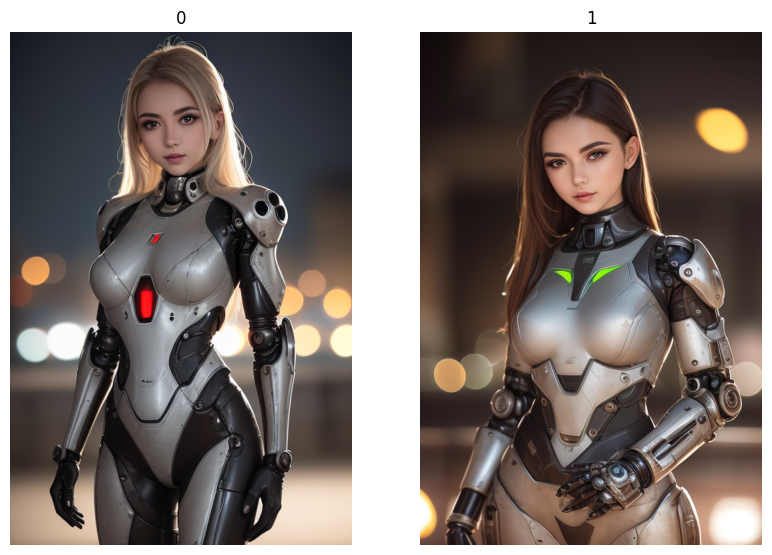

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_images(images, labels = None):
    N = len(images)
    n_cols = 3
    n_rows = int(np.ceil(N / n_cols))

    plt.figure(figsize = (5 * n_cols, 7 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        if labels is not None:
            plt.title(labels[i])
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()

prompt = "photo of beautifull girl in a worn mech suit, light bokeh, intricate, steel metal, elegant, sharp focus, soft lighting, vibrant colors"
negative_prompt="(worst quality, low quality:1.4), EasyNegativeV2, FastNegativeEmbedding"
sdloader.seed=15425
sdloader.setClipSkip(2)
images = sdloader.run(prompt, negative_prompt, 30, 8, 512, 768, 2)
plot_images(images, range(len(images)))

In [14]:
sdloader.unload()